## Table of Contents
1. 데이터 로딩
    + Language class 정의
    + Translation을 위한 pairwise data 로딩
2. 모델 정의하기
    + Sequence-to-sequence network 정의하기
    + Attention mechanism 적용하기 
3. 모델 학습 및 평가
4. Reference

In [59]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Machine Translation**

- Machine Translation (기계 번역)은 인공지능을 이용해 한 언어를 다른 언어로 번역하기 위한 기술
- 문장 내의 순차적인 연관 관계를 파악하기 위해 RNN이 사용됨
- 각 문장을 sequence로 변환하고, 하나의 sequence를 다른 sequence로 바꾸는 두개의 RNN이 함께 동작하는 sequence-to-sequence network를 사용
  - 문장을 sequence로 바꾸기 위하여 각 단어를 index 및 벡터로 표현하여 사용
  - Encoder RNN은 입력 sequence를 벡터로 압축하고, Decoder RNN은 벡터를 다른 언어의 새로운 sequence로 펼침.
- Attention Mechanism을 사용해 decoder가 입력 sequence의 특정 범위에 집중 할 수 있도록 하여 추가적인 성능 개선이 가능함.


### **1. 데이터 로딩**
- 실습에 사용할 영어-프랑스어 번역 데이터를 다운로드 받는다
- 각 단어를 One-hot 벡터 (하나의 성분만 1이고 나머지 성분은 모두 0인 벡터)로 표현한다.
  - 이를 위해 단어를 index로 변환하기 위한 ``word2index`` 함수와 ``index2work`` 함수를 이용한다
- 데이터를 단순화 하기 위해서 모든 문자를 소문자로 만들고, 문장 기호를 대부분 삭제한다 (``normalizeString`` 함수 이용).
- 문장 데이터를 문장의 시작 구문 및 문장의 단어 개수로 필터링한다.

In [60]:
if not os.path.exists('data'):
  !wget https://download.pytorch.org/tutorial/data.zip
  !unzip data.zip

In [61]:
SOS_token = 0 #Start of Sentence 
EOS_token = 1 #End of Sentence


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [62]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [63]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [64]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

### **2. 모델 정의하기**
- Translation을 위해 Sequence-to-Sequence network (**Seq2Seq network**)을 사용
  - 단일 RNN을 통한 sequence 처리는 입력과 출력의 개수가 같으므로 서로 다른 언어 사이의 번역에 사용하기에 한계가 있음.
  - Encoder-Decoder 구조를 갖는 Seq2Seq 모델은 **입력과 출력 sequence 길이에 제약이 없어** 번역에 사용하기에 적합한 모델
- Encoder RNN은 입력된 sequence를 벡터로 encoding
  - 입력된 문장 (sequence)의 **의미**를 벡터로 encoding
- Decoder RNN은 입력된 벡터를 sequence로 decoding
  - 입력된 벡터의 **의미**를 다른 언어의 문장 (sequence)로 decoding


- Encoder로 다음과 같은 모델을 사용
  - **Word embedding**을 학습하기 위해 ``nn.Embedding``을 사용
  - RNN cell로 Gated Recurrent Unit (GRU) 사용
- **Word embedding**
  - 단어를 특정 차원의 벡터로 바꾸어주는 것 
  - 학습을 통해 획득하는 Matrix를 통해 One-hot 벡터로 표현된 단어를 벡터로 변환
  - 단어간의 유사도가 벡터에 반영됨 - 유사한 의미를 갖는 단어들은 유사한 형태의 벡터로 변환
- Gated Recurrent Unit (GRU) 
  - LSTM과 마찬가지로 RNN의 long-term dependency 문제를 해결할 수 있는 구조
  - LSTM에 비해 구조가 간단함
  
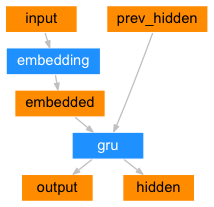

In [65]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

- Decoder로 다음과 같은 모델을 사용할 수 있음 
  - Seq2Seq encoder의 마지막 출력만을 사용하는 가장 간단한 decoder
  - Encoder의 마지막 출력은 전체 sequence의 문맥을 모두 포함하기 때문에 context 벡터로 불림
  
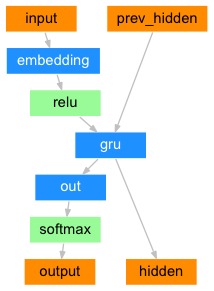

In [66]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        attn_weights = None
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

- **Attention**
  - 크기가 큰 입력의 일부분에 **집중(Attention)** 하도록 하는 기술
  - 입력의 각 부분에 대응하는 가중치를 생성하여 입력 값의 크기를 조정하거나, 다양한 입력을 적절하게 결합 할 수 있음

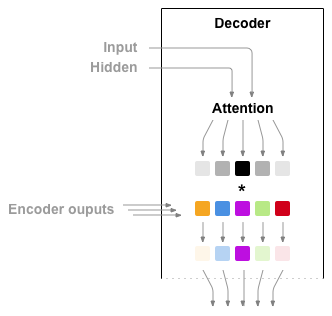

-  Attention을 도입하여 다음과 같은 Decoder를 구성할 수 있음
  - Attention을 통해 Decoder가 각 단계별로 Encoder 출력의 다른 부분에 집중할 수 있다
  - Attention layer (``attn`` layer)는 decoder의 입력 및 state를 이용해 encoder의 각 단계에서 얻어지는 각 출력들에 곱해지기 위한 가중치를 생성
  - Attention을 도입한 attentive decoder는 입력의 길이만큼의 attention을 생성해야 하기 때문에 정의시에 데이터셋의 최대 입력 길이가 필요

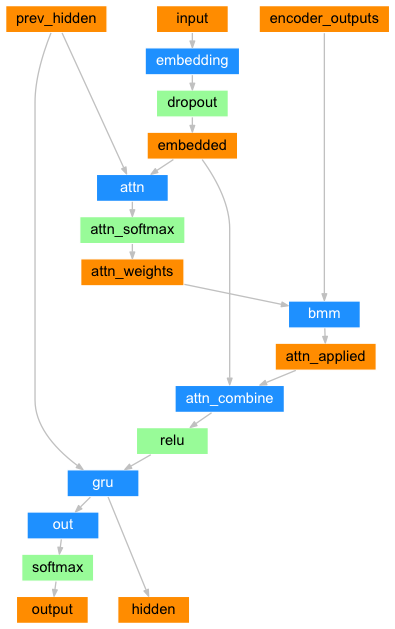

In [67]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### **3. 모델의 학습 및 평가**


- 학습 데이터를 준비하기 위해 다음과 같은 함수들을 정의한다.
  - 각 단어를 index로 변환하는 함수
  - 문장 및 문장의 pair를 tensor로 변환하기 위한 함수

In [68]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

- 학습을 위한 ``train``함수를 정의한다.
- ``train``함수는 다음과 같은 순서로 진행된다.
  - Encoder에 주어진 문장의 단어들을 모두 넣어 encoder의 모든 출력과 마지막 hidden state를 획득
  - Encoder의 마지막 hidden state를 decoder에 최초 hidden state로 입력
  - 순차적으로 decoder output을 획득하여 target과 비교를 수행
  - Loss를 계산하고 학습을 수행 
  - Teacher forcing: 학습 과정에서 decoder의 output을 다음 단계에서 입력으로 넣는 과정에서 decoder의 추론 결과 대신 target을 사용

In [69]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

- 남은 시간 및 진행률을 표시하기 위한 함수를 다음과 같이 정의한다

In [70]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

- ``train`` 함수를 여러번 호출하며 진행률, 예상 시간 및 평균 손실을 출력한다.

In [71]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

- 결과를 visualize하기 위한 함수를 다음과 같이 정의한다.

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

- 평가를 위한 ``evaluate``함수를 정의한다.
- ``evaluate``함수는 ``train``학습과 대부분 동일하나, 다음과 같은 차이가 있다.
  - Decoder의 추론 결과를 항상 다음 단계에서 입력으로 사용한다. 
  - 문장 종료 (EOS)가 예측되면 문장을 멈춘다.
  - 도식화를 위한 attention 출력을 저장한다. 

In [73]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            if decoder_attention is not None:
              decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

- Dataset 내의 임의의 문장에 대해 평가를 수행한다.
- 동일한 문장에 대해 서로 다른 decoder를 사용하는 2가지 모델의 번역 결과 함께 출력하여 결과를 비교한다.

In [74]:
def evaluateRandomly(encoder1, decoder1, encoder2, decoder2, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder1, decoder1, pair[0])
        output_words2, attentions2 = evaluate(encoder2, decoder2, pair[0])

        output_sentence = ' '.join(output_words)
        print('<', output_sentence, '- Simple Decoder')
        output_sentence2 = ' '.join(output_words2)
        print('<', output_sentence2, '- Attentive Decoder')
        print('')

- Decoder의 종류가 다른 2가지의 모델을 다음과 같이 정의한다. 

In [75]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


- 모델의 학습 및 저장을 다음과 같이 수행할 수 있다.
  - 모델의 저장에는 ``torch.save`` 함수를 사용한다.
  - ``nn.Module``을 상속한 신경망의 parameter들을 ``.state_dict()`` 메소드를 이용해 dictionary 형태로 불러온다
  - 저장할 다양한 신경망의 parameter들을 dictionary 형태로 묶어 ``torch.save``를 이용해 저장한다.  


0m 3s (- 0m 43s) (50 6%) 4.7499
0m 6s (- 0m 43s) (100 13%) 4.0454
0m 9s (- 0m 39s) (150 20%) 3.6420
0m 13s (- 0m 38s) (200 26%) 3.5447
0m 17s (- 0m 35s) (250 33%) 3.4254
0m 20s (- 0m 31s) (300 40%) 3.3320
0m 24s (- 0m 28s) (350 46%) 3.4672
0m 28s (- 0m 24s) (400 53%) 3.4093
0m 31s (- 0m 21s) (450 60%) 3.4381
0m 35s (- 0m 17s) (500 66%) 3.3096
0m 39s (- 0m 14s) (550 73%) 3.4826
0m 43s (- 0m 10s) (600 80%) 3.4793
0m 46s (- 0m 7s) (650 86%) 3.4221
0m 50s (- 0m 3s) (700 93%) 3.3498
0m 55s (- 0m 0s) (750 100%) 3.3536
0m 3s (- 0m 52s) (50 6%) 5.3156
0m 7s (- 0m 46s) (100 13%) 3.9941
0m 11s (- 0m 46s) (150 20%) 3.7298
0m 15s (- 0m 42s) (200 26%) 3.5123
0m 19s (- 0m 38s) (250 33%) 3.5997
0m 23s (- 0m 35s) (300 40%) 3.2878
0m 27s (- 0m 31s) (350 46%) 3.3421
0m 31s (- 0m 27s) (400 53%) 3.3876
0m 35s (- 0m 23s) (450 60%) 3.2694
0m 40s (- 0m 20s) (500 66%) 3.4045
0m 45s (- 0m 16s) (550 73%) 3.3717
0m 49s (- 0m 12s) (600 80%) 3.3373
0m 54s (- 0m 8s) (650 86%) 3.4350
0m 59s (- 0m 4s) (700 93%) 3.171

<Figure size 432x288 with 0 Axes>

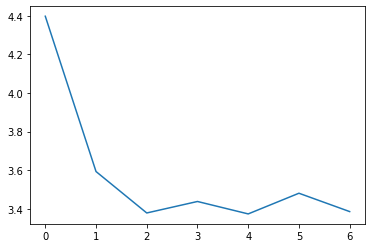

<Figure size 432x288 with 0 Axes>

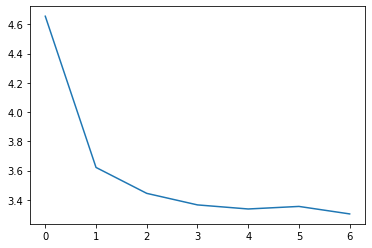

In [76]:
trainIters(encoder1, decoder, 75000, print_every=5000)
#torch.save({'encoder_state_dict':encoder1.state_dict(), 'decoder_state_dict':decoder.state_dict()}, 'RNN_translator.tar')

trainIters(encoder2, attn_decoder, 75000, print_every=5000)
#torch.save({'encoder_state_dict':encoder2.state_dict(), 'attn_decoder_state_dict':attn_decoder.state_dict()}, 'RNN_translator_Attn.tar')

- 학습된 모델을 다음과 같이 평가한다. 

In [77]:
evaluateRandomly(encoder1, decoder, encoder2, attn_decoder, n=10)

> elle est toujours aussi pauvre .
= she is as poor as ever .
< i re not . . <EOS> - Simple Decoder
< i m not very . <EOS> - Attentive Decoder

> je ne fais que blaguer .
= i am only joking .
< i re not . . <EOS> - Simple Decoder
< i m not very . <EOS> - Attentive Decoder

> il est vraiment egoiste .
= he s really selfish .
< you re not . . <EOS> - Simple Decoder
< i m not . . <EOS> - Attentive Decoder

> je manque de pratique .
= i m out of practice .
< i re not . . <EOS> - Simple Decoder
< i m not . <EOS> - Attentive Decoder

> nous sommes en train de nous echapper .
= we re escaping .
< i re not . . <EOS> - Simple Decoder
< i m not very . <EOS> - Attentive Decoder

> je suis une patiente .
= i m a patient .
< i re not . . <EOS> - Simple Decoder
< i m not . . <EOS> - Attentive Decoder

> vous n etes pas autorises a stationner la .
= you aren t allowed to park there .
< i re not . . <EOS> - Simple Decoder
< i m not not . . <EOS> - Attentive Decoder

> je suis certaine de son honnetete

- 학습이 완료된 모델을 다운로드 하여 불러온다.
  - ``torch.load`` 함수를 이용해 파일에 저장된 parameter의 dictionary를 불러온다.
  - 각 신경망의 parameter를 ``.load_state_dict()`` 메소드를 이용해 저장된 parameter로 덮어 씌운다. 

In [78]:
!pip install gdown
!gdown --id 1YOyXcRHJmEI41J_W1TxNHyyvHWgXQU_I
!gdown --id 1xBHZZdgOEmVzp5JKTyZRdepBwVgYXMwQ

checkpoint = torch.load('RNN_translator.tar', map_location = device)
encoder1.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

checkpoint = torch.load('RNN_translator_Attn.tar', map_location = device)
encoder2.load_state_dict(checkpoint['encoder_state_dict'])
attn_decoder.load_state_dict(checkpoint['attn_decoder_state_dict'])


Downloading...
From: https://drive.google.com/uc?id=1YOyXcRHJmEI41J_W1TxNHyyvHWgXQU_I
To: /content/RNN_translator.tar
13.4MB [00:00, 62.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xBHZZdgOEmVzp5JKTyZRdepBwVgYXMwQ
To: /content/RNN_translator_Attn.tar
13.9MB [00:00, 122MB/s]


<All keys matched successfully>

- 불러온 모델을 다음과 같이 평가한다. 



In [79]:
evaluateRandomly(encoder1, decoder, encoder2, attn_decoder, n=10)

> vous etes tres contraries .
= you re very upset .
< you re very upset . <EOS> - Simple Decoder
< you re very upset . <EOS> - Attentive Decoder

> vous etes charmants .
= you re charming .
< you re charming . <EOS> - Simple Decoder
< you re charming . <EOS> - Attentive Decoder

> nous sommes separes .
= we re separated .
< we re separated . <EOS> - Simple Decoder
< we re resilient . <EOS> - Attentive Decoder

> elles mentent toutes .
= they re all lying .
< they re all waiting . <EOS> - Simple Decoder
< they re all lying . <EOS> - Attentive Decoder

> vous etes tous a moi .
= you re all mine .
< you re all mine . <EOS> - Simple Decoder
< you re all mine . <EOS> - Attentive Decoder

> elles ne sont pas encore chez elles .
= they re not home yet .
< they re not home yet . <EOS> - Simple Decoder
< they re not home yet . <EOS> - Attentive Decoder

> c est un enfant pourri gate .
= he is a spoiled child .
< he is a spoiled child . <EOS> - Simple Decoder
< he is a child child . <EOS> - Atte

- Attentive decoder를 이용한 모델의 번역 과정에서 계산된 attention을 다음과 같이 visualize한다.

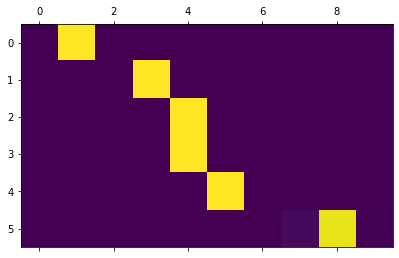

In [80]:
output_words, attentions = evaluate(
    encoder2, attn_decoder, "je suis trop froid .")
%matplotlib inline
plt.matshow(attentions.numpy())


- Attention의 visualization을 다양한 문장에 대해 수행한다.

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


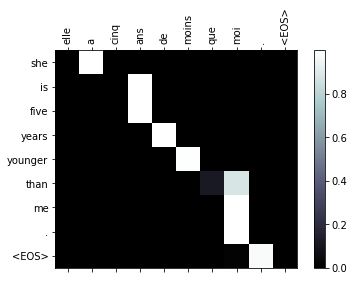

input = elle est trop petit .
output = she is too short . <EOS>


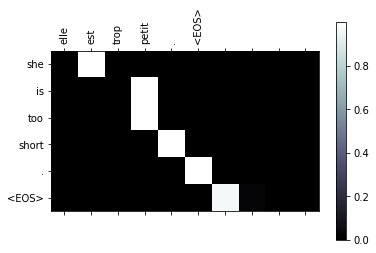

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


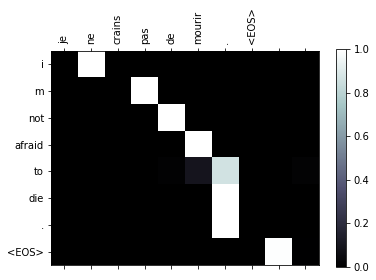

input = c est un jeune directeur plein de talent .
output = he s a talented . <EOS>


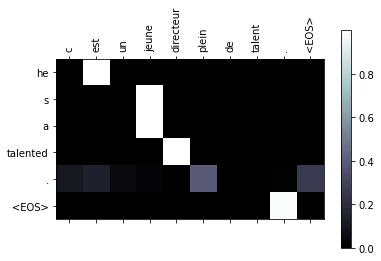

In [81]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## 6. Reference
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html